# Analysis of A/B Testing Results

There is an international online store.

There are the results of the A/B tests launched from 2020-12-07 to 2021-01-01, and the technical specification of one of the tests.

Technical description
* Test name: recommender_system_test
* Groups: А (control), B (new payment funnel)
* Launch date: 2020-12-07
* Date when they stopped taking up new users: 2020-12-21
* End date: 2021-01-01
* Audience: 15% of the new users from the EU region
* Purpose of the test: testing changes related to the introduction of an improved recommendation system
* Expected result: within 14 days of signing up, users will show better conversion into product page views (the product_page event), instances of adding items to the shopping cart (product_cart), and purchases (purchase). At each stage of the funnel product_page → product_cart → purchase, there will be at least a 10% increase.
* Expected number of test participants: 6000

The purpose of the study: to check if the tests were carried out correctly and analyze the results of the A/B tests. 


The work plan:

<a href='#section1'>1. Getting the data and studying the general information</a>

<a href='#section2'>2. Data preprocessing</a>

<a href='#section3'>3. Exploratory data analysis of A/B testing data</a>

<a href='#section4'>4. Evalueting the results of the A/B tests</a>

<a href='#section5'>5. Overall Conclusion</a>

In [1]:
#importing of libraries
import pandas as pd
from datetime import datetime
import numpy as np
from scipy import stats as st
import seaborn as sns
from matplotlib import pyplot as plt

#some global constats for formatting the output string
BOLD = '\033[1m'
END = '\033[0m'

# function to calculate p-value for an independent proportion z-test
def proportions_diff_z_test(successes1, successes2, n1, n2, alternative = 'two-sided'):

    # proportion for success in the first group
    p1 = successes1 / n1
    # proportion for success in the second group
    p2 = successes2 / n2 
    # proportion in a combined dataset
    P = (successes1 + successes2) / (n1 + n2)
    
    # calculating z-test statistic
    z_stat = (p1 - p2) / np.sqrt(P * (1 - P) * (1 / n1 + 1 / n2))

    # return p-value for independent proportion z-test
    if alternative == 'two-sided':
        return 2 * (1 - st.norm(0, 1).cdf(abs(z_stat)))
    
    if alternative == 'less':
        return stats.norm(0, 1).cdf(z_stat)

    if alternative == 'greater':
        return 1 - st.norm(0, 1).cdf(z_stat)

# function to calculate p-value for the proportion z-test between two groups for the event specified
def proportions_diff_pvalue(experiment_results, group1, group2, event):
    
    successes1 = experiment_results[experiment_results.index==event][group1].iloc[0]
    successes2 = experiment_results[experiment_results.index==event][group2].iloc[0]
    
    n1 = experiment_results[experiment_results.index=='all_users'][group1].iloc[0]
    n2 = experiment_results[experiment_results.index=='all_users'][group2].iloc[0]

    return proportions_diff_z_test(successes1, successes2, n1, n2)


# function to highlight the event name
def event_name_color(col):
    
    if col.name != 'event_name':
        return [''] * len(col)

    color = col.map({
        'login': 'blue',
        'product_page': 'green',
        'product_cart': 'orange',
        'purchase': 'red'})
    return 'color:' + color

# function to highlight one session actions 
def row_style(row):
    
    if row.session_id % 2 == 1:
        return pd.Series('background-color: #f5fdff', row.index)
    else:
        return pd.Series('background-color: #fff9f0', row.index)

## 1. Getting the Data and Studying the General Information
<a id='section1'></a>

In [2]:
# reading files that contain the A/B test data 
marketing_campaign = pd.read_csv('/datasets/ab_project_marketing_events_us.csv')
users = pd.read_csv('/datasets/final_ab_new_users_upd_us.csv')
user_events_log = pd.read_csv('/datasets/final_ab_events_upd_us.csv')
ab_groups = pd.read_csv('/datasets/final_ab_participants_upd_us.csv')

# creating the list of tables and their descriptions
tables = [marketing_campaign, users, user_events_log, ab_groups]
descriptions = ['the calendar of marketing campaign for 2020', 'user information',
                'events log', 'A/B testing information'] 

for i, (table, description) in enumerate(zip(tables, descriptions)):
    # looking at the data's general information.
    print(BOLD + 'General inforamation about the table contains ' 
          + description + ':' + END)
    table.info()
    print()
    
    #looking at the first few rows in a table
    print(BOLD + 'The first rows of the table contains ' 
      + description + ':' + END)
    display(table.head())
    print()

General inforamation about the table contains the calendar of marketing campaign for 2020:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
name         14 non-null object
regions      14 non-null object
start_dt     14 non-null object
finish_dt    14 non-null object
dtypes: object(4)
memory usage: 576.0+ bytes

The first rows of the table contains the calendar of marketing campaign for 2020:


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11



General inforamation about the table contains user information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
user_id       58703 non-null object
first_date    58703 non-null object
region        58703 non-null object
device        58703 non-null object
dtypes: object(4)
memory usage: 1.8+ MB

The first rows of the table contains user information:


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone



General inforamation about the table contains events log:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
user_id       423761 non-null object
event_dt      423761 non-null object
event_name    423761 non-null object
details       60314 non-null float64
dtypes: float64(1), object(3)
memory usage: 12.9+ MB

The first rows of the table contains events log:


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99



General inforamation about the table contains A/B testing information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
user_id    14525 non-null object
group      14525 non-null object
ab_test    14525 non-null object
dtypes: object(3)
memory usage: 340.6+ KB

The first rows of the table contains A/B testing information:


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test


The dataset contains 423,761 pageview log records for 58,703 users. 14,525 users took part in A/B tests.

The first table contans information on 14 marketing campaign conducted in 2020. It is worth checking if campaigns coincided with the AB testing.

For the `'start_dt'`, `'finish_dt'`, `'first_date'`, and `'event_dt'` columns, it's nessecary to change the type to datetime to make it convenient to work with dates. For the `'device'`, `'event_name'`, `'group'`, and `'ab_test'` columns we could change the type from object to categorical one, but this is optional, since the tables in the dataset are small initially.

Only the `'details'` column of the table with events logs have null values, and a significant part of the values are missing. The same cost in the column `'details'` is occurred several times, perhaps there are only a few price categories.

In [3]:
# Let's take a look at the values that the 'detail' column takes.
# creating the table with all values of the 'detail' column and their frequencies
price_categories = user_events_log.groupby('details').event_dt.count().reset_index()\
                      .rename(columns={'details':'pirce', 'event_dt':'purchase_num'})
price_categories['purchase_share'] = round(100 * price_categories.purchase_num / price_categories.purchase_num.sum(),
                                           2)
print(BOLD + 'The values that the price takes:' + END)
display(price_categories)

The values that the price takes:


,pirce,purchase_num,purchase_share
0,4.99,44579,73.91
1,9.99,9158,15.18
2,99.99,5405,8.96
3,499.99,1172,1.94


There are only 4 price options. 4.99 most popular, 74% of purchases were made at this price. And only 2 percent of purchases cost 499.99.

In [4]:
# Let's look at the values that take categorical features 
print(BOLD + 'Categorical features' + END)
for table, cols, descr in zip([users, user_events_log, ab_groups],
                              [['region','device'], ['event_name'], ['group', 'ab_test']],
                              descriptions[1:]):
    print("The columns with categorical values in the table containing data on " + BOLD + descr + END + ':')
    pd.set_option('display.max_colwidth', -1)
    display(table[cols].agg(['unique', 'nunique']).T)
    print()
    
# Let's look at date range in the dataset
print(BOLD + 'Features containing dates' + END)
for table, date_cols, descr in zip([users, user_events_log], [['first_date'], ['event_dt']],
                              descriptions[1:3]):
    print("Date range in the table containing data on " + BOLD + descr + END + ':')
    display(table[date_cols].agg(['min', 'max']))

Categorical features
The columns with categorical values in the table containing data on user information:


,unique,nunique
region,"[EU, N.America, APAC, CIS]",4
device,"[PC, Android, iPhone, Mac]",4



The columns with categorical values in the table containing data on events log:


,unique,nunique
event_name,"[purchase, product_cart, product_page, login]",4



The columns with categorical values in the table containing data on A/B testing information:


,unique,nunique
group,"[A, B]",2
ab_test,"[recommender_system_test, interface_eu_test]",2



Features containing dates
Date range in the table containing data on user information:


,first_date
min,2020-12-07
max,2020-12-23


Date range in the table containing data on events log:


,event_dt
min,2020-12-07 00:00:33
max,2020-12-30 23:36:33


The dataset contains users from 4 regions: EU, N.America, APAC, CIS, who use 4 types of devices.

The dataset contains data regarding 4 events:
* Went to login page (`login`)
* Navigated to the page of a product (`product_page`)
* Viewed the cart (`product_cart`)
* Paid for the order (`purchase`)  

Two A/B tests were conducted:
* recommender system test
* interface (EU) test

The tests were conducted during more than 3 weeks (from December 7th to December 7th, 2020):  group A is the control and group B has shown corresponding changes. The last date when new users were registered is December 23rd.

In [5]:
# Let's look at all 14 marketing campaign and their dates 
print(BOLD + 'Marketing campaigns for 2020:' + END)
display(marketing_campaign)

Marketing campaigns for 2020:


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


At the time of A/B testing, the "Christmas & New Year Promo" campaign was launched, this could bias the test results. We will assume that an ad campaign equally affects its participants, but can change the behavior of users in comparison with those who do not participate in it. Then in the A/B experiments there should not be both users participating in this campaign and not participating in it, i.e. the experiments should only contain users from EU, N.America or only from APAC, CIS.

In [6]:
# Let's look at the number of users in different tables in the dataset
print(BOLD + 'The number of unique users in the dataset: {:,}.'.format(users.user_id.nunique()) + END)
print(BOLD + 'The number of unique users who have logs : {:,}.'.format(user_events_log.user_id.nunique()) + END)
print(BOLD + 'The number of unique users who took part in the experiments: {:,}, which is {:.2%} of all users.'\
                  .format(ab_groups.user_id.nunique(), 
                          ab_groups.user_id.nunique()/users.user_id.nunique()) + END)
print()

# function to print data on distribution of the number of users by groups
def print_distr_users_by_test_experiments():
    print('The number of users in A and B experiments in the recommender system and interface(EU) tests:')
    display(ab_groups.pivot_table(index='ab_test', columns='group', values='user_id', aggfunc='count'))

    print('Share of users in A and B experiments in both tests:')
    display(ab_groups.pivot_table(index='ab_test', columns='group', values='user_id', aggfunc='count')\
        .div(ab_groups.groupby('ab_test').user_id.count(), axis=0).round(2)*100)
    

print(BOLD + 'Distribution of the number of users by test experiments' + END)
print_distr_users_by_test_experiments()

The number of unique users in the dataset: 58,703.
The number of unique users who have logs : 58,703.
The number of unique users who took part in the experiments: 13,638, which is 23.23% of all users.

Distribution of the number of users by test experiments
The number of users in A and B experiments in the recommender system and interface(EU) tests:


group,A,B
ab_test,,
interface_eu_test,5467,5383
recommender_system_test,2747,928


Share of users in A and B experiments in both tests:


group,A,B
ab_test,,
interface_eu_test,50.0,50.0
recommender_system_test,75.0,25.0


Log records are available for all users of the dataset. Almost 22% of users took part in the A/B tests. The number of unique users (13,638) is less than the number of entries in the table with A/B tests (14,525, see general info). This means there are users who participated in both tests (interface (EU) and recommender system tests) or in both experiments (A and B).

Each experiment of the interface (EU) test involves about 5.4 thousand users. Thus, the shares of users in experiments are evenly distributed. By contrast, the share of users in the recommender system testing experiments is unevenly distributed. Only 25% of users taking part in the test saw the changes corresponding to new recomendation system. 

In [7]:
# Let's define on which users there were intersections and their amount.
users_in_both_experiments = set(ab_groups.query("ab_test=='recommender_system_test'").user_id)\
                            &set(ab_groups.query("ab_test=='interface_eu_test'").user_id)
print(BOLD + "The number of users who took part in both tests (recommender system test and interface EU test):",
      len(users_in_both_experiments), END)

print(BOLD + "The number of users who took part in both A and B experiments in the recommender system test:",
      len(set(ab_groups.query("group=='A' and ab_test=='recommender_system_test'").user_id)
          &set(ab_groups.query("group=='B' and ab_test=='recommender_system_test'").user_id)), END)

print(BOLD + "The number of users who took part in both A and B experiments in the interface (EU) test:",
      len(set(ab_groups.query("group=='A' and ab_test=='interface_eu_test'").user_id)
          &set(ab_groups.query("group=='B' and ab_test=='interface_eu_test'").user_id)), END)

The number of users who took part in both tests (recommender system test and interface EU test): 887 
The number of users who took part in both A and B experiments in the recommender system test: 0 
The number of users who took part in both A and B experiments in the interface (EU) test: 0 


The intersection of groups A and B by visitors is empty for both tests, but there are 887 users who took part in both tests. We should drop the visitors that got into 2 tests since we can't know for sure what they saw and what influenced their behavior.

## 2. Data Preprocessing
<a id='section2'></a>

### Feature Renaming and Data Type Replacement

In [8]:
# Let's use an uniform approach to date columns names to make it convenient to work with them.
# renaming columns
marketing_campaign.rename(columns={'start_dt': 'start_date',
                                   'finish_dt': 'finish_date'}, inplace=True)

user_events_log.rename(columns={'event_dt': 'event_date'}, inplace=True)

# converting date columns to datatime type:
marketing_campaign['start_date'] = pd.to_datetime(marketing_campaign.start_date, format='%Y-%m-%d')
marketing_campaign['finish_date'] = pd.to_datetime(marketing_campaign.finish_date, format='%Y-%m-%d')
users['first_date'] = pd.to_datetime(users.first_date, format='%Y-%m-%d')
user_events_log['event_date'] = pd.to_datetime(user_events_log.event_date)

The type for the `'start_dt'`, `'finish_dt'`, `'first_date'`, and `'event_dt'` columns was changed to datetime to make them convenient to work with it.

The names of the date columns have been changed to uniform ones for more convenient work with them. 

### Examing and Processing Missing Values

In [9]:
# Let's take a look at the percentage of missing values in the 'details' column depending on the type of event.
print(BOLD + 'Share of missing values in the log table by events:' + END)
(100*user_events_log[user_events_log.details.isnull()].groupby('event_name').event_date.count()\
    /user_events_log.groupby('event_name').event_date.count()).fillna(0).reset_index()

Share of missing values in the log table by events:


,event_name,event_date
0,login,100.0
1,product_cart,100.0
2,product_page,100.0
3,purchase,0.0


The `'details'` column contains the price for the `purchase` event only and there are no missing values for this type of event. For all other events, the value is undefined and we can leave the null value as unavailable.

### Examing and Processing Duplicates

In [10]:
# Let's look at duplicates  
print(BOLD + 'Full duplicates:' + END)
for table, descr in zip([users, user_events_log, ab_groups], descriptions[1:]):
    print("The number of full duplicates in the table containing data on " + BOLD + descr + END + ':',
          len(table[table.duplicated()]))
print()
print(BOLD + 'Duplicates in particular columns:' + END)
duplicated_day_and_time = len(user_events_log[user_events_log.duplicated(['user_id', 'event_date'], keep=False)])
print('The number of user ' + BOLD + 'events recorded on the same day and time' + BOLD 
      + ': ' + END + '{:,},'.format(duplicated_day_and_time),
      'which is {:.2%} of all log records.'.format(duplicated_day_and_time/len(user_events_log)))
print()

print(BOLD + 'Some examples of events recorded on the same day and time:' + END)
display(user_events_log[user_events_log.duplicated(['user_id', 'event_date'], keep=False)]\
    .sort_values(['user_id', 'event_date']).head(20)\
        .assign(time_diff = lambda x: (x.event_date-x.event_date.shift(1)).fillna(''),
                session_id = lambda x: (x.event_date-x.event_date.shift(1) > pd.Timedelta(0, 's')).cumsum()+1)\
            .style.apply(event_name_color).apply(row_style, axis=1).hide_index())

Full duplicates:
The number of full duplicates in the table containing data on user information: 0
The number of full duplicates in the table containing data on events log: 0
The number of full duplicates in the table containing data on A/B testing information: 0

Duplicates in particular columns:
The number of user events recorded on the same day and time: 258,002, which is 60.88% of all log records.

Some examples of events recorded on the same day and time:


user_id,event_date,event_name,details,time_diff,session_id
000199F1887AE5E6,2020-12-14 09:56:09,purchase,4.99,,1
000199F1887AE5E6,2020-12-14 09:56:09,product_page,nan,0 days 00:00:00,1
000199F1887AE5E6,2020-12-14 09:56:09,login,nan,0 days 00:00:00,1
000199F1887AE5E6,2020-12-15 07:22:56,purchase,4.99,0 days 21:26:47,2
000199F1887AE5E6,2020-12-15 07:22:56,product_cart,nan,0 days 00:00:00,2
000199F1887AE5E6,2020-12-15 07:22:56,product_page,nan,0 days 00:00:00,2
000199F1887AE5E6,2020-12-15 07:22:56,login,nan,0 days 00:00:00,2
000199F1887AE5E6,2020-12-20 06:36:35,purchase,4.99,4 days 23:13:39,3
000199F1887AE5E6,2020-12-20 06:36:35,product_cart,nan,0 days 00:00:00,3
000199F1887AE5E6,2020-12-20 06:36:35,login,nan,0 days 00:00:00,3


There are no full duplicates in the dataset. 

Nevertheles we have several events of different types recorded on the same day and time. It happens that all 4 types of events are recorded on the same date and time with an accuracy of seconds. Perhaps the user goes to the product page, to the cart, and starts to place an order as an anonymous user and only sign in when he or she is making a purchase. Only after that we are able to write down his or her logs.

In addition, we have duplicate users who participated in both tests (see investigations above), which need removing from consideration when analyzing the results of A/B tests.

In [11]:
# Let's remove users who took part in both tests
ab_groups = ab_groups[~ab_groups.user_id.isin(users_in_both_experiments)]

print(BOLD 
      + 'Distribution of the number of users by test experiments after removing users who took part in both tests'
      + END)
print_distr_users_by_test_experiments()

Distribution of the number of users by test experiments after removing users who took part in both tests
The number of users in A and B experiments in the recommender system and interface(EU) tests:


group,A,B
ab_test,,
interface_eu_test,5011,4952
recommender_system_test,2082,706


Share of users in A and B experiments in both tests:


group,A,B
ab_test,,
interface_eu_test,50.0,50.0
recommender_system_test,75.0,25.0


We have removed users who took part in both tests from table contains A/B testing information. The user shares of A and B experiments did not change for both tests.

### Processing users who took part in the marketing campaign and who did not

In [12]:
# Let's look at the regions from where the users who took part in the tests.
print(BOLD + 'Distribution of the number of users by region in the experiments of both tests:' + END)
display(ab_groups.merge(users, on='user_id').pivot_table(index='region', columns=['ab_test', 'group'],
                                                         values='user_id', aggfunc='count').fillna(0))

Distribution of the number of users by region in the experiments of both tests:


ab_test   interface_eu_test         recommender_system_test       
group                     A       B                       A      B
region                                                            
APAC       0.0               0.0     28.0                    17.0 
CIS        0.0               0.0     19.0                    11.0 
EU         5011.0            4952.0  1939.0                  655.0
N.America  0.0               0.0     96.0                    23.0

The users who took part in the interface (EU) test were only from Europe, which corresponds to the name. Users from 4 different regions took part in the recommender system test, but most of them are from Europe. But only European and North American users participated in the 'Christmas and New Year Promo' marketing campaign. Accordingly, we need to remove APAC and CIS regions from consideration.

Note that the share of European users in the recommender system test significantly exceeds 15% required in the technical description of the test.

There are very few observations from North America, their share in different experiments is also different: 5% of users in control group A and 3% in group B, perhaps in the remaining two regions (Europe and North America) react differently to changes and this may affect on the overall test result.

In [13]:
# Let's remove users from APAC and CIS regions 
# since they didn't take part in the Christmas & New Year Promo but most of the users in the tests did. 
ab_groups = ab_groups.merge(users, on='user_id').query("region=='EU' or region=='N.America'")[ab_groups.columns]

We only kept users from two regions to avoid bias due to users from other regions not participating in the promo.

### Handling users from different regions

In [14]:
# Let's consider the impact of the region on the A/B test result.
print(BOLD 
      + 'Distribution of the number of events of different types in two regions in both groups of '
      + 'recommender system test:' + END)
conversion_by_region = user_events_log.merge(ab_groups.query("ab_test=='recommender_system_test'")\
                                                 .merge(users, on='user_id'),
                                             on='user_id', how='inner')\
                          .pivot_table(index='event_name', columns=['region', 'group'],
                                       values='user_id', aggfunc='count')
display(conversion_by_region)

print(BOLD 
      + 'Conversion rate of each stage in two regions in both groups of recommender system test:' 
      + END)
display(conversion_by_region.div(conversion_by_region.loc['login'], axis=1).round(2)*100)

Distribution of the number of events of different types in two regions in both groups of recommender system test:


region          EU       N.America    
group            A     B         A   B
event_name                            
login         5876  1781  283       71
product_cart  1802  489   80        8 
product_page  3806  946   211       33
purchase      1774  485   105       13

Conversion rate of each stage in two regions in both groups of recommender system test:


region           EU        N.America       
group             A      B         A      B
event_name                                 
login         100.0  100.0  100.0     100.0
product_cart  31.0   27.0   28.0      11.0 
product_page  65.0   53.0   75.0      46.0 
purchase      30.0   27.0   37.0      18.0

Conversion at different stages for both regions differs noticeably, but there are too few observations for the North American region. Thus, we can only keep users from Europe.

Note that the conversion at all stages for group B is lower than for group A for both regions, for North America this is most appreciable.

In [15]:
# Let's remove users from N.America region as well
ab_groups = ab_groups.merge(users, on='user_id').query("region=='EU'")[ab_groups.columns]

Hereinafter, we will consider the results of A/B testing only for users from the European region, since it is necessary to examine each region separately, and for other regions there is not enough data.

## 3. Exploratory Data Analysis of A/B Testing Data
<a id='section3'></a>

Event funnel of users proceed from each stage in interface_eu_test:


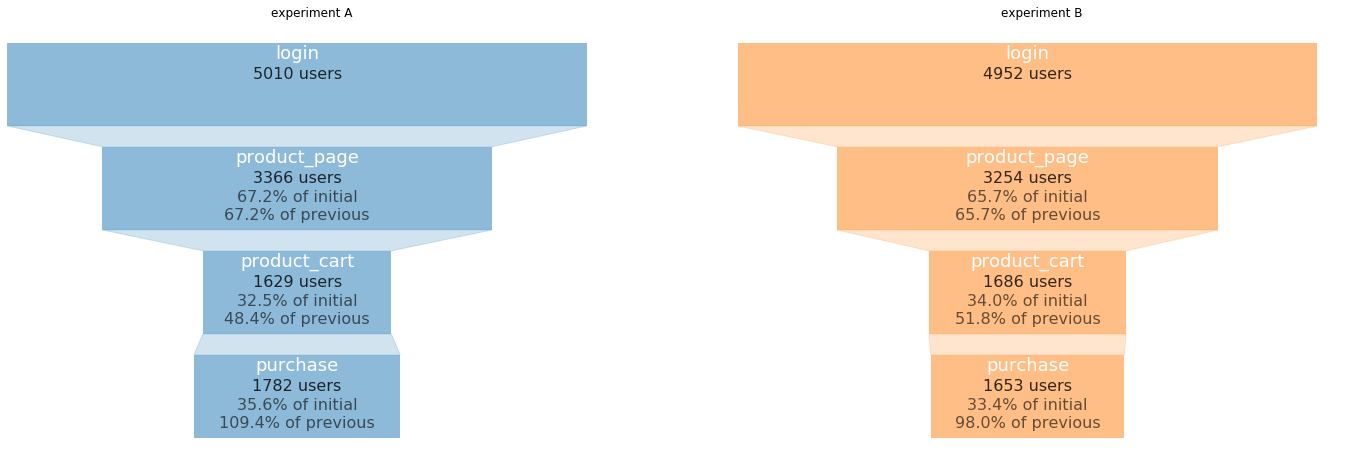

Event funnel of users proceed from each stage in recommender_system_test:


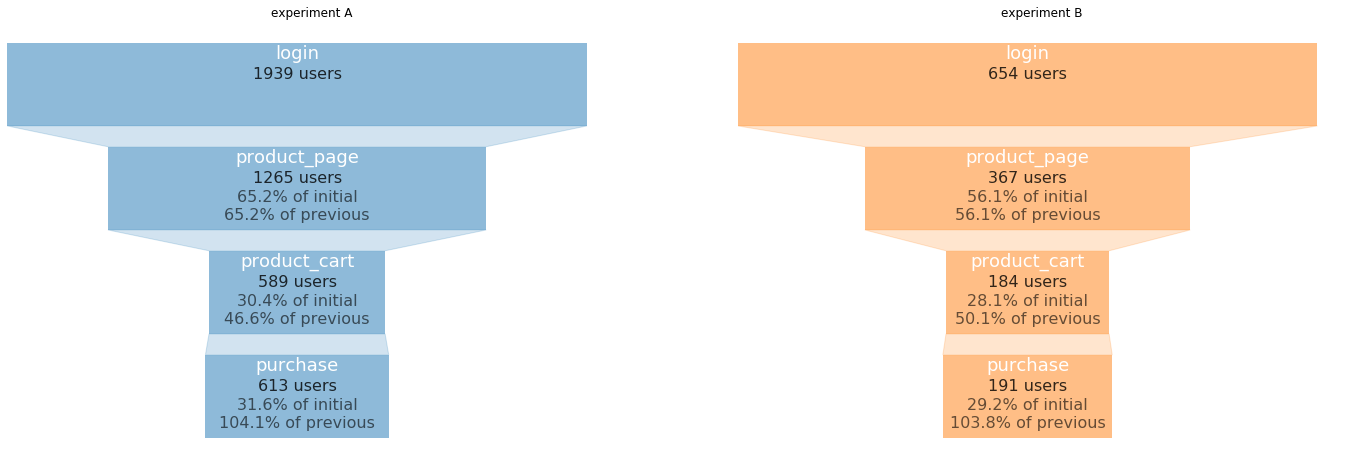

In [16]:
# Let's study conversion at different funnel stages
# creating sequence of events
events_sequence = ['login', 'product_page', 'product_cart', 'purchase']


# function to plot event funnel
def plot_funnel(quantities_by_events, ax, color):
    
    conversion = quantities_by_events / quantities_by_events[0] * 100
    y = range(len(quantities_by_events), 0, -1)
    next_stage_ration = quantities_by_events / quantities_by_events.shift(1) * 100
    
    quantities_labels = ['{:} users'.format(x) for x in quantities_by_events]
    conversion_labels = ['{:.1f}% of initial'.format(x) for x in conversion]
    next_stage_ration_labels = ['{:.1f}% of previous'.format(x) for x in next_stage_ration]

    for i, value in enumerate(conversion):
        left = (100 - value) / 2
        ax.barh(y[i], conversion[i], left = left, color=color, alpha=0.5, height=.8)
        
        ax.text(50, y[i]+0.25, quantities_by_events.index[i], ha='center', fontsize=18, color='w')
        
        ax.text(50, y[i]+0.05, quantities_labels[i], ha='center', fontsize=16, alpha=0.8)

        if i > 0:
            ax.text(50, y[i]-0.125, conversion_labels[i], ha='center', fontsize=16, alpha=0.6)
        
            ax.text(50, y[i]-0.3, next_stage_ration_labels[i], ha='center', fontsize=16, alpha=0.6)

        if i != len(quantities_by_events) - 1:
            next_left = (100 - conversion[i+1]) / 2
            shadow_x = [left, next_left, 100-next_left, 100-left, left]
            shadow_y = [y[i]-0.4, y[i+1]+0.4, y[i+1]+0.4, y[i]-0.4, y[i]-0.4]
            ax.fill(shadow_x, shadow_y, color=color, alpha=0.2)
    ax.axis('off')

# Let's plot event funnels for each group of both tests.
for test, test_data in user_events_log.merge(ab_groups, on='user_id', how='inner').groupby('ab_test'):
    fig, axes = plt.subplots(ncols=2, figsize=(12*2, 8))
    print('Event funnel of users proceed from each stage in ' + BOLD + test + ':' + END)
    for i, (group, group_data) in enumerate(test_data.groupby('group')): 
        quantities_by_events = group_data.groupby('event_name').user_id.nunique().loc[events_sequence]
        plot_funnel(quantities_by_events, axes[i], '#1f77b4' if group=='A' else '#ff7f0e');
        axes[i].set_title('experiment ' + group)
    plt.show()

According to the plotted funnels, it can be seen that the product cart page is not necessary for making purchases: the number of purchases can be more than the number of visits to the product cart page.

The shares of users by event for the interface (EU) test look evenly distributed, with minor differences in conversion rates. About 5000 users took part in each experiment (group A and group B).

Much fewer users took part in the recommendation system test: about 2 thousand users in group A and only 650 users who saw the corresponding changes, which is not enough to track statistically significant improvements required according to the technical description (based on the available data, 6,000 users are required to achieve a statistically significant minimum detectable effect of 10%). Note that the share of users who went to the product page is almost 10% less for users from group B, which practically did not affect the share of users who made a purchase in comparison with group B.

Note that equal proportions in groups A and B are not required to test the statistical difference between proportions.

Distribution of the number of events per user in the tests
The number of events per user in interface_eu_test:


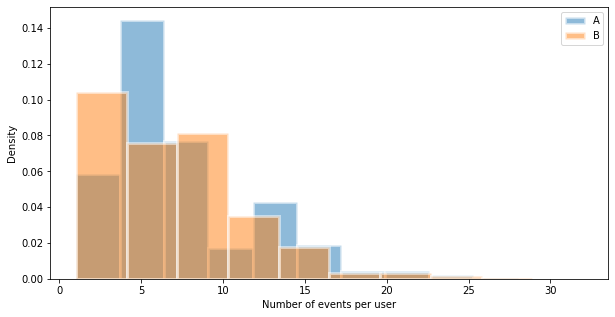

The number of events per user in recommender_system_test:


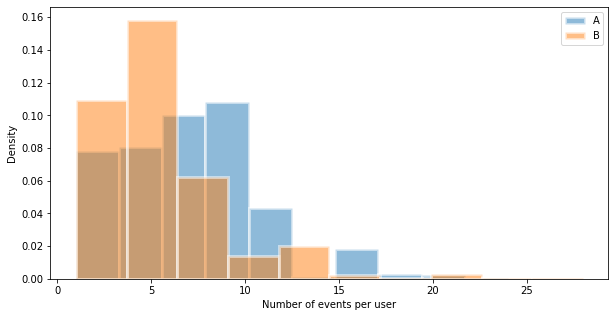

In [17]:
# Let's look at the number of events per user to make sure they are evenly distributed in the samples
print(BOLD + 'Distribution of the number of events per user in the tests' + END)
for test, test_data in ab_groups.groupby('ab_test'):
    print('The number of events per user in ' + BOLD + test + ':' + END)
    fig, ax = plt.subplots(figsize=(10, 5))
    for group, group_data in user_events_log.merge(test_data, on='user_id', how='inner').groupby('group'):
        group_data.groupby('user_id').event_name.count().hist(density=True, alpha=0.5, linewidth=3, edgecolor='w',
                                                              label=group, ax=ax)
    plt.legend(); 
    ax.grid(b=None)
    ax.set_xlabel('Number of events per user')
    ax.set_ylabel('Density')
    plt.show()

The distribution of the number of events per user in the interface (EU) test for both groups looks approximately the same without far stood out points.

The distribution of the number of events per user in the recommender system tests is shifted to the right towards a larger number of events for group A. This means that there are more loyal users and users who reach the purchase in group A, which can bias the results of the A/B test. Nevertheless, no anomalous values are observed either.

Amount of events by days
The number of events in interface_eu_test by days:


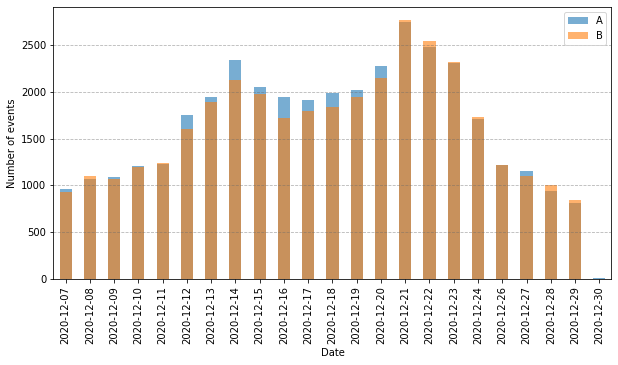

The number of events in recommender_system_test by days:


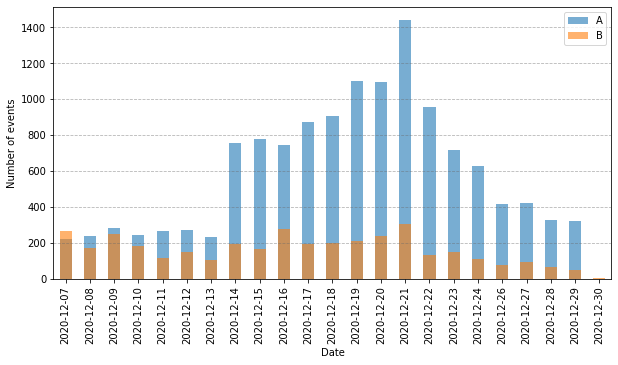

In [18]:
# Let's look at the number of events distributed by days
print(BOLD + 'Amount of events by days' + END)
for test, test_data in ab_groups.groupby('ab_test'):
    print('The number of events in ' + BOLD + test + END + ' by days:')
    fig, ax = plt.subplots(figsize=(10, 5))
    for group, group_data in user_events_log.merge(test_data, on='user_id', how='inner').groupby('group'):
        group_data.event_date.dt.date.value_counts(sort=False).sort_index()\
            .plot(kind='bar', ax=ax, alpha=0.6, label=group, color=next(ax._get_lines.prop_cycler)['color']);
    plt.legend(); 
    ax.grid(False)
    ax.grid(axis='y', linestyle='--', color='dimgray', alpha=0.5)
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of events')
    plt.show()

The distribution of the number of events by days in the interface (EU) test for both groups looks the same. The number of events grows with the addition of new users and decreases after new users are not added to the experiment.

The distribution of the number of events by day in the recommender system test is very different for both groups. In the first week, the number of events in group A was about the same, but then it increased sharply and continued to grow, after new users stopped adding to the test, the number of events decreased. In group B, the number of events per day most of the time was about the same, about 200. The first few days, amount of events was comparable to group A, then it decreased, slightly increased starting from the second week, after new users stopped adding, the number of events was also decreased. 

Trends in the number of events depends on the number of new users added to the tests by days.

Note that the date 2020-12-25 is missing. It is worth finding out what happened on that date.

In [ ]:
# Let's take a look at the number of users that have been added to the tests by day.
print(BOLD + 'Amount of registered users by days' + END)
for test, test_data in ab_groups.groupby('ab_test'):
    print('The number of registered users in ' + BOLD + test + END + ' by days:')
    fig, ax = plt.subplots(figsize=(10, 5))
    for group, group_data in user_events_log.merge(test_data.merge(users, on='user_id'),
                                                   on='user_id', how='inner').groupby('group'):
        group_data.groupby(group_data.first_date.dt.date).user_id.nunique().sort_index()\
            .plot(kind='bar', ax=ax, alpha=0.6, label=group, color=next(ax._get_lines.prop_cycler)['color']);
    plt.legend(); 
    ax.grid(False)
    ax.grid(axis='y', linestyle='--', color='dimgray', alpha=0.5)
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of registered users')
    plt.show()

The distribution of the number of new users by days in the interface (EU) test for both groups looks the same but it is not even. Trends in the distribution of users added to the test by day repeat trends in the number of events by day.

The distribution of the number of new users by days in the recommender system test is very different for both groups as well as for the number of events by days. Since the second week, the number of new users in group A has increased significantly, 5 times higher than for group B. Adding users unevenly to groups A and B can lead to biased test results, for example, due to the fact that more users in group A were able to participate in the 'Christmas and New Year' marketing campaign or, on some of the days, the site could be unstable.

In [20]:
# Users participating in the tests use different devices, this can also bias the A/B test results.
# Let's look at the distribution of the number of users by devices in the tests.
print(BOLD + 'Distribution of the number of users by devices:' + END)
users_num_by_device = ab_groups.merge(users, on='user_id').pivot_table(index='device', columns=['ab_test', 'group'],
                                                                       values='user_id', aggfunc='count')
display(users_num_by_device)
print()

print(BOLD + 'Distribution of the share of users by devices:' + END)
display(users_num_by_device.div(users_num_by_device.sum()).round(2)*100)

Distribution of the number of users by devices:


ab_test interface_eu_test       recommender_system_test     
group                   A     B                       A    B
device                                                      
Android  2218              2264  858                     309
Mac      511               515   177                     58 
PC       1302              1223  504                     158
iPhone   980               950   400                     130


Distribution of the share of users by devices:


ab_test interface_eu_test       recommender_system_test      
group                   A     B                       A     B
device                                                       
Android  44.0              46.0  44.0                    47.0
Mac      10.0              10.0  9.0                     9.0 
PC       26.0              25.0  26.0                    24.0
iPhone   20.0              19.0  21.0                    20.0

For all experiments of both tests, the distribution of devices looks the same: a significant part of users used Android, about 45% of users, together with 20% of users who used an iPhone, 65% of users used the mobile version of the site. About 25% of users used PC and only 10% used Mac. Uneven distribution across devices can bias the A/B test results. For example, users of the mobile version of the store can react differently to changes in the interface. As their share is higher, they have a greater impact on the results. It is necessary to conduct tests for each device separately or to be sure that the use of different devices does not affect the conversion at each stage.

## 4. Evalueting the results of the A/B tests
<a id='section4'></a>

The recommender system test was conducted inaccurately. Moreover, the interface (EU) test did not lead to a change in conversion (see the event funnels for groups A and B of the test). Let's make a group comparison to determine the potential for testing again.

In [21]:
# Let's look at the number of users who took part in both tests.
user_events_log.merge(ab_groups[['user_id', 'group', 'ab_test']], on='user_id').groupby('ab_test').user_id.nunique()\
    .reset_index()

,ab_test,user_id
0,interface_eu_test,9963
1,recommender_system_test,2594


The number of participating users is significantly less than 6000 as expected for the recommender systems test.

In [22]:
# Let's look at the number of users in each group by events and in total

# creating the pivot table with the number of users in each group by events and in total
experiment_results = user_events_log.merge(ab_groups, on='user_id')\
                         .pivot_table(index='event_name', values='user_id',
                                      columns=['ab_test', 'group'], aggfunc='nunique').loc[events_sequence]
experiment_results.loc['all_users'] = user_events_log.merge(ab_groups, on='user_id')\
                                          .groupby(['ab_test', 'group']).user_id.nunique()

print(BOLD + 'The number of users in each group by events and in total:' + END)
display(experiment_results)

print(BOLD + 'The share of users in each group by events:' + END)
display(round(experiment_results\
              .divide(experiment_results[experiment_results.index=='all_users'].iloc[0])*100,
        2)[:-1])

The number of users in each group by events and in total:


ab_test      interface_eu_test       recommender_system_test     
group                        A     B                       A    B
event_name                                                       
login         5010              4952  1939                    654
product_page  3366              3254  1265                    367
product_cart  1629              1686  589                     184
purchase      1782              1653  613                     191
all_users     5011              4952  1939                    655

The share of users in each group by events:


ab_test      interface_eu_test         recommender_system_test       
group                        A       B                       A      B
event_name                                                           
login         99.98             100.00  100.00                  99.85
product_page  67.17             65.71   65.24                   56.03
product_cart  32.51             34.05   30.38                   28.09
purchase      35.56             33.38   31.61                   29.16

Both groups of the interface (EU) test involve about 5 thousand users each. The shares of users by events look evenly distributed. 

The number of users in group B of the recommender system test is significantly less than in group A, but this should not affect the result of testing the hypothesis of equality of proportions.

Note login page does not appear for all users and the product cart page is not necessary for making purchases (the number of purchases can be more than the number of visits to the product cart page).

Let's test hypotheses, assuming that the changes being tested are not affected by the type of device the user is using.

In [23]:
# Let's see if there is a statistically significant difference between groups

# Let's calculate p-value for the proportion z-test between both groups by event
# and write the results to the log
test_log = pd.DataFrame(columns=['test_name', 'event_name', 'p'])
i = 0
for test in ab_groups.ab_test.unique():
    for event in events_sequence:
        test_log.loc[i] = [test, event, proportions_diff_pvalue(experiment_results[test], 'A', 'B', event)]
        i += 1
    
print('Hypotheses:')
print(BOLD + 'H\u2080: The proportions of users performed the event in A and B groups are equel.')
print('H\u2081: The proportions of users performed the event in A and B groups are not equel')
print(END)
    
print(BOLD + 'p-value for the proportion z-test between both groups by event:' + END)
display(test_log)

Hypotheses:
H₀: The proportions of users performed the event in A and B groups are equel.
H₁: The proportions of users performed the event in A and B groups are not equel

p-value for the proportion z-test between both groups by event:


,test_name,event_name,p
0,recommender_system_test,login,0.085272
1,recommender_system_test,product_page,0.000025
2,recommender_system_test,product_cart,0.268993
3,recommender_system_test,purchase,0.240358
4,interface_eu_test,login,0.320152
5,interface_eu_test,product_page,0.122441
6,interface_eu_test,product_cart,0.103234
7,interface_eu_test,purchase,0.021998


We tested 4 hypotheses on the same data for each test. If we want an overall alpha of 0.05, the significance level of each test should be 0.05 / 4 = 0.0125 according to the Bonferoni correction procedure. Thus, we can reject only one null hypothesis about the equality of the proportion of users who went to the product page in groups A and B in the recommender system test. The share of users who went to the product page is almost 10% less for users from group B. Perhaps the introduction of an improved recommendation system led to the fact that users immediately went to the purchase without additional viewing product details. But at the same time this did not lead to a change in the share of users who made a purchase. It might be worth taking advantage of event-based analytics to take a closer look at the behavior of users and see exactly how users use the new recommender system.

In [24]:
# Let's look at the number of users in each group by events and in total for different devices

# creating the pivot table with the number of users in each group by events and in total for different devices
conversion_by_device = user_events_log.merge(ab_groups.merge(users, on='user_id'),
                                             on='user_id', how='inner')\
                          .pivot_table(index='event_name', columns=['ab_test', 'device', 'group'],
                                       values='user_id', aggfunc='nunique').loc[events_sequence]
conversion_by_device.loc['all_users'] = user_events_log.merge(ab_groups.merge(users, on='user_id'),
                                                              on='user_id', how='inner')\
                                            .groupby(['ab_test', 'device', 'group']).user_id.nunique()

print(BOLD + 'The number of users in each group by events and in total for different devices:' + END)
display(conversion_by_device)
print()

print(BOLD + 'The share of users in each group by events for different devices:' + END)
display((conversion_by_device.div(conversion_by_device.loc['login'], axis=1).round(2)*100)[:-1])

The number of users in each group by events and in total for different devices:


ab_test      interface_eu_test                                          \
device                 Android        Mac         PC       iPhone        
group                        A     B    A    B     A     B      A    B   
event_name                                                               
login         2218              2264  511  515  1301  1223  980    950   
product_page  1496              1520  337  339  878   795   655    600   
product_cart  720               777   167  188  437   422   305    299   
purchase      777               758   187  167  466   402   352    326   
all_users     2218              2264  511  515  1302  1223  980    950   

ab_test      recommender_system_test                                      
device                       Android       Mac       PC      iPhone       
group                              A    B    A   B    A    B      A    B  
event_name                                                                
login         858                     308  177  58  504  158  400    130  
product_page  545                     175  127  37  331  81   262    74   
product_cart  264                     82   54   16  143  38   128    48   
purchase      269                     93   69   19  152  42   123    37   
all_users     858                     309  177  58  504  158  400    130


The share of users in each group by events for different devices:


ab_test      interface_eu_test                                            \
device                 Android           Mac            PC        iPhone   
group                        A      B      A      B      A      B      A   
event_name                                                                 
login         100.0             100.0  100.0  100.0  100.0  100.0  100.0   
product_page  67.0              67.0   66.0   66.0   67.0   65.0   67.0    
product_cart  32.0              34.0   33.0   37.0   34.0   35.0   31.0    
purchase      35.0              33.0   37.0   32.0   36.0   33.0   36.0    

ab_test             recommender_system_test                              \
device                              Android           Mac            PC   
group             B                       A      B      A      B      A   
event_name                                                                
login         100.0  100.0                   100.0  100.0  100.0  100.0   
product_page  63.0   64.0                    57.0   72.0   64.0   66.0    
product_cart  31.0   31.0                    27.0   31.0   28.0   28.0    
purchase      34.0   31.0                    30.0   39.0   33.0   30.0    

ab_test                            
device              iPhone         
group             B      A      B  
event_name                         
login         100.0  100.0  100.0  
product_page  51.0   66.0   57.0   
product_cart  24.0   32.0   37.0   
purchase      27.0   31.0   28.0

When looking at users on different devices separately, there are very few observations for the recommender system test, especially for those using a Mac. 

The shares of users by events for the interface (EU) test look evenly distributed for all groups and devices. 
For the recommender system test, product page conversions are higher for group B compared to group A for all devices.

In [25]:
# Let's see if there are statistically significant differences between groups for different devices 

# Let's calculate p-value for the proportion z-test between both groups by event for each device
# and write the results to the log
test_log = pd.DataFrame(columns=['test_name', 'device', 'event_name', 'p'])
i = 0
for test in ab_groups.ab_test.unique():
    for device in users.device.unique():
        for event in events_sequence[1:]:
            test_log.loc[i] = [test, device, event, proportions_diff_pvalue(conversion_by_device[test][device],
                                                                            'A', 'B', event)]
            i += 1
            
print('Hypotheses:')
print(BOLD + 'H\u2080: The proportions of users performed the event in A and B groups are equel.')
print('H\u2081: The proportions of users performed the event in A and B groups are not equel')
print(END)
    
print(BOLD + 'p-value for the proportion z-test between both groups by event:' + END)
display(test_log)

Hypotheses:
H₀: The proportions of users performed the event in A and B groups are equel.
H₁: The proportions of users performed the event in A and B groups are not equel

p-value for the proportion z-test between both groups by event:


,test_name,device,event_name,p
0,recommender_system_test,PC,product_page,0.001115
1,recommender_system_test,PC,product_cart,0.287503
2,recommender_system_test,PC,purchase,0.388803
3,recommender_system_test,Android,product_page,0.032770
4,recommender_system_test,Android,product_cart,0.162511
5,recommender_system_test,Android,purchase,0.682616
6,recommender_system_test,iPhone,product_page,0.077799
7,recommender_system_test,iPhone,product_cart,0.300471
8,recommender_system_test,iPhone,purchase,0.621470
9,recommender_system_test,Mac,product_page,0.251992


We tested 12 additional hypotheses on the same data for each test. If we want an overall alpha of 0.05, the significance level of each test should be 0.05 / 16 = 0.003125 according to the Bonferoni correction procedure. Thus, we can reject only one null hypothesis about the equality of the proportion of users who went to the product page in groups A and B in the recommender system test for PC. The share of users who went to the product page is 15% less for users from group B. 

## 5. Overall Conclusions
<a id='section5'></a>

There are a page views logs of users of the online store, some of which showed a new recommendation system or a modified interface in order to conduct appropriate AB tests.

The dataset contains 423,761 pageview log records for 58,703 users.
The dataset contains data regarding 4 events:

* Went to login page (login)
* Navigated to the page of a product (product_page)
* Viewed the cart (product_cart)
* Paid for the order (purchase)

About 20% users took part in two A/B tests conducted during more than 3 weeks (from December 7th to December 7th, 2020). The timing of one of the 14 marketing campaigns overlapped with both A/B tests. The dataset contains users from 4 regions: EU, N.America, APAC, CIS, who use 4 types of devices.

The recommender system test performed does not match the following description items:
* the share of users from Europe is considerably over 15%
* the number of participating users is significantly less than 6000

Moreover, both tests were conducted inaccurately:
* There is partial overlapping with the marketing campaigns might bias the test results especially if the distribution of users among groups A and B was uneven these days. It is better if the test is not carried out simultaneously with an ad campaign (we can select users from regions where the ad campaign is not being conducted) or the periods overlap completely.
* There are users who participated in both tests. We cannot use A/B test results on these users since we don't know for sure what they saw and what influenced their behavior. 
* The share of users in the recommender system test is unevenly distributed between A and B groups.
* There are users from different regions who react differently to tested changes. It is necessary to examine each region separately, and there is enough data for each region.
* The distribution of the number of users by days in the recommender system test is not similar for A and B groups. It might lead to bias in the test results. For example, an ad company can differently affect the conversion in groups A and B, or the unstable operation of the site on some of the days can cause a bias.
* The shares of users with different devices are not equal. Uneven distribution across devices can bias the A/B test results. For example, users of the mobile version of the store can react differently to changes in the interface. As their share is higher, they have a greater impact on the results. It is necessary to conduct tests for each device separately or to be sure that the use of different devices does not affect the conversion at each stage.

We cannot expect the reproducibility of tests in production. It is necessary to correct all the shortcomings and re-run tests if we are interested in finding out the impact of the proposed changes.

After deleting users who participated in both tests and leaving only European users (there is not enough data for the rest of the regions to consider them separately), we tested the hypotheses about the equality of the proportion of users who perform each event in groups A and B. We got a statistically significant difference between the proportion of users who went to the product page in two groups in the recommendation system test. The share of users from group B is almost 10% less than for users from group A. 

If assume that the changes being tested are affected by the type of device the user is utilizing, we got a statistically significant difference between the proportion of users who went to the product page in two groups only in the recommender system test for PC. The share of users from group B is 15% less than for users from group A. 

Perhaps the introduction of an improved recommendation system led to the fact that users immediately went to purchase without additional viewing product details (apparently it is more convenient to do this on a PC). But at the same time, this did not lead to a change in the share of users who made a purchase in A and B groups. It might be worth taking advantage of event-base analytics to take a closer look at user behavior and see exactly how users iteract with the new recommendation system.

Assuming that the interface changes being tested are not affected by the type of device the user is using, the interface test was carried out more accurately. We did not reveal a statistically significant difference between the control groups and the group with changed interface in terms of the proportion of users who performed each type of action. 